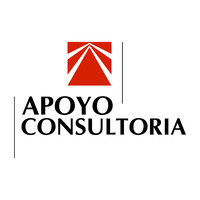
# Evaluación

Esta libreria realiza la evaluación de las proyecciones a frecuencia mensual.

### Librerias y rutas

In [1]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos
from ipynb.fs.defs.Kalman import interpol
from ipynb.fs.defs.Interpolacion import kalman_resultados
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
#Frecuencias de variables
frq1 = 3
frq2 = 1

In [3]:
rutaOrigen = 'inputs/'
rutaEstimacion = 'model_interpol/'
rutaDestino = 'resultados/'

### Importando base agregada

In [4]:
_,_,_,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
VariablesPBI = ['pbif_Trimestre_VariacionAnual',
               ]

### Evaluacion

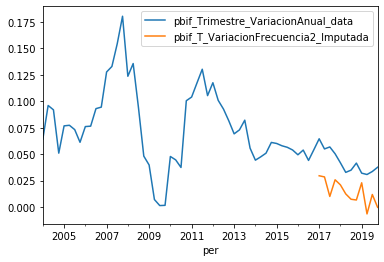

In [6]:
bd_eval = {}
models = {}
test_size_eval=36
for y in VariablesPBI:
    
    NombreVariableFrecuencia1Filtrada = y[0:6] + '_VariacionFrecuencia1_Filtrada'
    NombreVariableFrecuencia2Filtrada = y[0:6] + '_VariacionFrecuencia2_Filtrada'

    NombreVariableFrecuencia1Imputada = y[0:6] + '_VariacionFrecuencia1_Imputada'
    NombreVariableFrecuencia2Imputada = y[0:6] + '_VariacionFrecuencia2_Imputada'
    
    bd_pred_1s = pd.DataFrame()
    
    for test_size in range(test_size_eval,0,-1):

        BaseInterpolacion,_,_ = kalman_resultados(rutaEstimacion + 'ModelosKalman.xlsx', bd_all, y, frq1, frq2,test_size)

        if test_size>0:

            bd_pred = BaseInterpolacion[[y + '_data'] + [NombreVariableFrecuencia2Imputada]][-test_size:]
            bd_pred = bd_pred[bd_pred[y + '_data'] != 0].dropna()
            bd_pred = bd_pred[:1]
 
            if len(bd_pred.index.tolist())>0:
                if not(bd_pred.index[0] in bd_pred_1s.index):
                    bd_pred_1s = bd_pred_1s.append(bd_pred)
    
    bd_eval[y] = {'MAE': mean_absolute_error(bd_pred_1s[y + '_data'],bd_pred_1s[NombreVariableFrecuencia2Imputada]),
                    'R2': r2_score(bd_pred_1s[y + '_data'],bd_pred_1s[NombreVariableFrecuencia2Imputada]),
                    'RMSE': mean_squared_error(bd_pred_1s[y + '_data'],bd_pred_1s[NombreVariableFrecuencia2Imputada])**0.5
                   }
    
    BaseInterpolacion.loc[BaseInterpolacion[y + '_data'] != 0,[y + '_data']].join(bd_pred_1s.drop([y + '_data'], axis =1)).plot()
    
    plt.show()


In [7]:
pd.DataFrame(bd_eval).transpose()

,MAE,R2,RMSE
pbif_Trimestre_VariacionAnual,0.028543,-6.744489,0.030176


### Model Checker

#### Importando modelos en forma de pandas

In [8]:
model = 0
VariablesPBI[model]

'pbif_Trimestre_VariacionAnual'

In [9]:
bd_model = pd.read_excel(rutaEstimacion + 'ModelosKalman.xlsx',sheet_name = VariablesPBI[model][0:20], index_col = 0 )

y = [VariablesPBI[model]]
X = bd_model.index[3:].tolist()

frq1 = 3
frq2 = 1

test_size=32

ParametrosOptimizados = bd_model.Valor.values.tolist()

In [10]:
bd_model

,Valor,STD,T
Phi,0.446555,NaN,NaN
Rho,0.407223,NaN,NaN
Sigma^2,0.000083,NaN,NaN
imae_com_car_Mensual_VariacionAnual,0.023075,0.006711,3.438620
imae_com_imp_vl_Mensual_VariacionAnual,0.020987,0.008337,2.517403
ipc1_viv_Mensual_VariacionAnual,0.041647,0.041145,1.012201
ipc1_trp_Mensual_VariacionAnual,0.043668,0.021517,2.029475


In [11]:
_, KalmanInterpolador, BaseInterpolacion = interpol(bd_all,X,y,frq1,frq2,ParametrosOptimizados,test_size)

### Interpolacion

###### Serie Usada

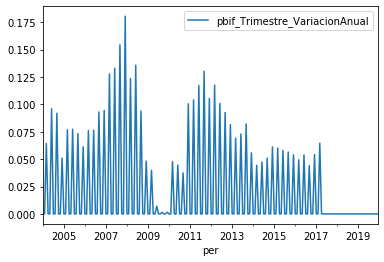

In [12]:
BaseInterpolacion[y].plot()

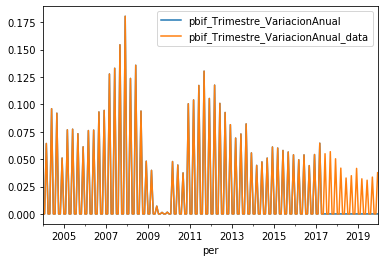

In [13]:
BaseInterpolacion[y + [y[0] + '_data']].plot()

In [14]:
NombreVariableFrecuencia1Filtrada = y[0][0:6] + '_VariacionFrecuencia1_Filtrada'
NombreVariableFrecuencia2Filtrada = y[0][0:6] + '_VariacionFrecuencia2_Filtrada'

NombreVariableFrecuencia1Imputada = y[0][0:6] + '_VariacionFrecuencia1_Imputada'
NombreVariableFrecuencia2Imputada = y[0][0:6] + '_VariacionFrecuencia2_Imputada'


BaseInterpolacion[NombreVariableFrecuencia1Filtrada] = pd.DataFrame(KalmanInterpolador.filter(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
BaseInterpolacion[NombreVariableFrecuencia2Filtrada] = BaseInterpolacion[NombreVariableFrecuencia1Filtrada].rolling(int(frq1/frq2)).mean()
BaseInterpolacion[NombreVariableFrecuencia1Imputada] = pd.DataFrame(KalmanInterpolador.smooth(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
BaseInterpolacion[NombreVariableFrecuencia2Imputada] = BaseInterpolacion[NombreVariableFrecuencia1Imputada].rolling(int(frq1/frq2)).mean()

###### Variables que interpolan

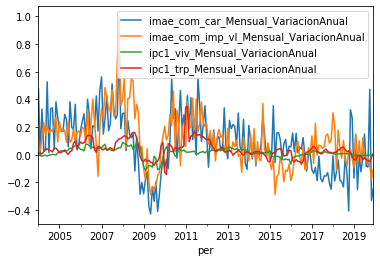

In [15]:
BaseInterpolacion[X].plot()

##### Interpolacion - Crecimiento Anual

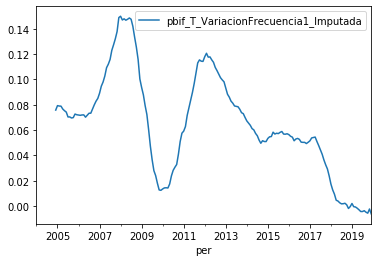

In [16]:
BaseInterpolacion[[NombreVariableFrecuencia1Imputada]].rolling(12).mean().plot()

###### Interpolacion - Baja frecuencia

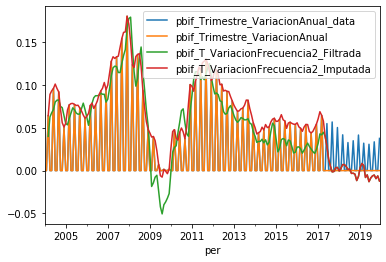

In [17]:
BaseInterpolacion[[y[0] + '_data'] + y + [NombreVariableFrecuencia2Filtrada,NombreVariableFrecuencia2Imputada]].plot()

###### Interpolacion - Alta frecuencia

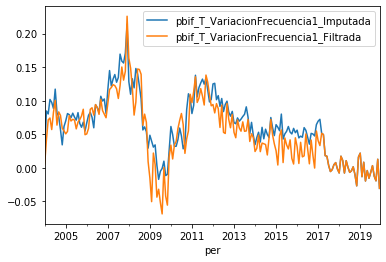

In [18]:
BaseInterpolacion[[NombreVariableFrecuencia1Imputada,NombreVariableFrecuencia1Filtrada]].plot()

In [19]:
BaseInterpolacion[[NombreVariableFrecuencia1Imputada,NombreVariableFrecuencia1Filtrada]][-12:]

,pbif_T_VariacionFrecuencia1_Imputada,pbif_T_VariacionFrecuencia1_Filtrada
per,,
2019-01-01,0.021961,0.021961
2019-02-01,-0.013070,-0.013070
2019-03-01,0.008448,0.008448
2019-04-01,-0.019516,-0.019516
2019-05-01,-0.003972,-0.003972
2019-06-01,-0.015381,-0.015381
2019-07-01,-0.006626,-0.006626
2019-08-01,0.003360,0.003360
2019-09-01,-0.012422,-0.012422


###### Correlaciones

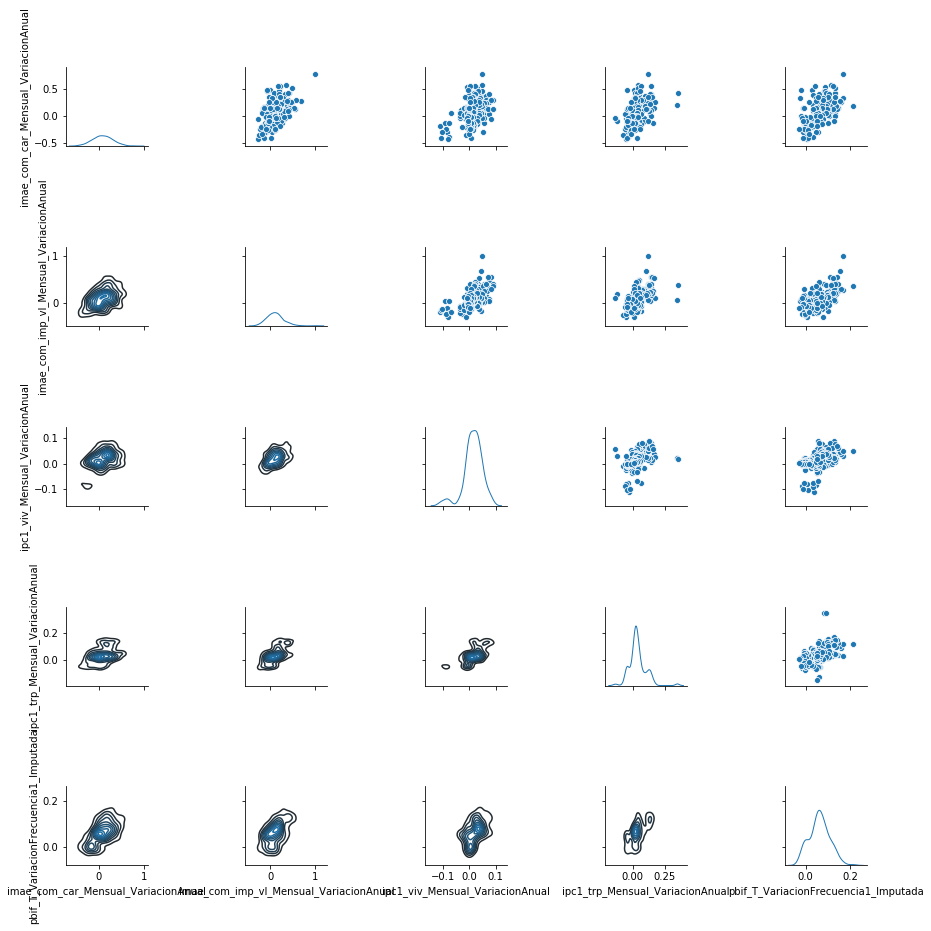

In [20]:
bd_temp = BaseInterpolacion[X + [NombreVariableFrecuencia1Imputada]]
g = sns.PairGrid(bd_temp)
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot, lw=1)